In [49]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

def summary(ndarr):
    print(ndarr)
    print("* shape: {}".format(ndarr.shape))
    print("* min: {}".format(np.min(ndarr)))
    print("* max: {}".format(np.max(ndarr)))
    print("* avg: {}".format(np.mean(ndarr)))
    print("* std: {}".format(np.std(ndarr)))
    print("* unique: {}".format(np.unique(ndarr)))

In [50]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

train_data = mnist.train
valid_data = mnist.validation
test_data = mnist.test

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [51]:
def plot_fatten_img(ndarr):
    img = ndarr.copy()
    img.shape = (28,28)
    plt.imshow(img, cmap='gray')
    plt.show()

In [64]:
class Autoencoder(object):
    def __init__(self,n_features,learning_rate=0.5,n_hidden=[128,64],alpha=0.0):
        self.n_features = n_features
        self.graph = tf.Graph()
        self.build(n_features,learning_rate,n_hidden,alpha)
        self.sess = tf.Session(graph=self.graph)
        
    def build(self,n_features,learning_rate,n_hidden,alpha):
        with self.graph.as_default():
            ### Input
            self.features = tf.placeholder(tf.float32, shape=(None,n_features))
            self.target  = tf.placeholder(tf.float32, shape=(None,n_features))
            
            ### Computation
            self.weights = {}
            self.biases = {}
            self.scores = {}
            self.X = {}
            
            # input layer
            self.weights['e1'], self.biases['e1'], self.scores['e1'] = self.getDenseLayer(self.features,n_hidden[0])
            
            # encoder layers
            self.X['e2'] = tf.nn.sigmoid(self.scores['e1'])
            self.weights['e2'], self.biases['e2'], self.scores['e2'] = self.getDenseLayer(self.X['e2'],n_hidden[1])
            
            # code layer
            self.code = tf.nn.sigmoid(self.scores['e2'])
            
            # decoder layers
            self.weights['d1'], self.biases['d1'], self.scores['d1'] = self.getDenseLayer(self.code,n_hidden[0])
            self.X['d2'] = tf.nn.sigmoid(self.scores['d1'])
            
            # output layer
            self.weights['d2'], self.biases['d2'], self.logits = self.getDenseLayer(self.X['d2'],n_features)
            self.y = tf.nn.sigmoid(self.logits)

            ### Optimalization
            self.original_loss = tf.reduce_mean(tf.pow(self.y - self.target, 2))
            
            all_weights = [w for k,w in self.weights.items()]
            self.regularization = tf.nn.l2_loss(all_weights[0])
            for w in all_weights[1:]:
                self.regularization += tf.nn.l2_loss(w)
                
            self.loss = self.original_loss + alpha * self.regularization
            
            self.train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(self.loss)
            self.init_op = tf.global_variables_initializer()  
            
    def getDenseLayer(self,input_layer,n_output):
        with self.graph.as_default():
            n_input = int(input_layer.shape[1])
            W = tf.Variable(
                    tf.truncated_normal( shape=(n_input,n_output) ))
            b = tf.Variable(tf.zeros( shape=(n_output) ))
            s = tf.add(tf.matmul(input_layer,W),b)
        return (W,b,s)
    
    
    def fit(self,X,y,epochs=10,validation_data=None,test_data=None,batch_size=None):
        N = X.shape[0]
        random.seed(9000)
        if not batch_size: batch_size=N
        
        self.sess.run(self.init_op)
        for epoch in range(epochs):
            print("Epoch %2d/%2d: "%(epoch+1,epochs))
            index = random.shuffle([i for i in range(N)])

            k = 0
            while k < N:
                batch_index = [i for i in range(k,min(k+batch_size,N))]    
            
                feed_dict = {self.features: X[batch_index,:], self.target: y[batch_index,:]}
                _, loss, predictions = self.sess.run([self.train_op, self.loss, self.y], feed_dict=feed_dict)

                print("[%d/%d] loss = %9.4f                      " % ( k, N, loss ), end='\r')
                
                k += batch_size
            
            msg_valid = ""
            if validation_data:
                val_loss = self.evaluate(validation_data[0],validation_data[1])
                msg_valid = ", val_loss = %9.4f" % ( val_loss )
            
            train_loss = self.evaluate(X,y)
            print("[%d/%d] loss = %9.4f %s" % ( N, N, train_loss, msg_valid ))
            
           # reverse_imgs = self.predict(test_data[0])
            #plot_fatten_img(reverse_imgs[10])
            
        if test_data:
            test_loss = self.evaluate(test_data[0],test_data[1])
            print("test_loss = %9.4f" % (test_loss))
    
    def predict(self,X):
        if len(X.shape)==1: X = np.reshape(X,(1,X.shape[0]))
        return self.sess.run(self.y, feed_dict={self.features: X})
    
    def evaluate(self,X,y):
        if len(X.shape)==1: X = np.reshape(X,(1,X.shape[0]))
        if len(y.shape)==1: y = np.reshape(y,(1,y.shape[0]))
        return self.sess.run(self.loss, feed_dict={self.features: X, self.target: y})


In [ ]:
model = Autoencoder( n_features=28*28,
                     learning_rate= 0.02,
                     n_hidden=[256,128],
                     alpha=0.00,
                    )
model.fit(X=train_data.images,
          y=train_data.images,
          epochs=10,
          validation_data=(valid_data.images,valid_data.images),
          test_data=(test_data.images,test_data.images),
          batch_size = 256,
         )

Epoch  1/10: 
[55000/55000] loss =    0.0794 , val_loss =    0.0793
Epoch  2/10: 
[55000/55000] loss =    0.0747 , val_loss =    0.0745
Epoch  3/10: 
[55000/55000] loss =    0.0730 , val_loss =    0.0729
Epoch  4/10: 
[55000/55000] loss =    0.0699 , val_loss =    0.0699
Epoch  5/10: 
[55000/55000] loss =    0.0682 , val_loss =    0.0682
Epoch  6/10: 
[55000/55000] loss =    0.0690 , val_loss =    0.0689
Epoch  7/10: 
[55000/55000] loss =    0.0697 , val_loss =    0.0695
Epoch  8/10: 
[55000/55000] loss =    0.0669 , val_loss =    0.0669
Epoch  9/10: 
[55000/55000] loss =    0.0663 , val_loss =    0.0663
Epoch 10/10: 


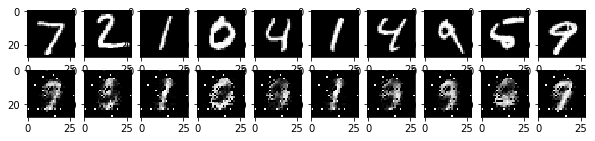

In [63]:
fig, axis = plt.subplots(2, 10, figsize=(10, 2))

for i in range(0,10):
    img_original = np.reshape(test_data.images[i],(28,28))
    axis[0][i].imshow(img_original, cmap='gray')
    img = np.reshape(model.predict(test_data.images[i]),(28,28))
    axis[1][i].imshow(img, cmap='gray')
plt.show()